# Playtester

Playtester notebook for the FINCH Predictive Coder Neural Network

# Setup

After running the setup cells, restart the runtime. Colab needs to refresh the updated libraries.

(this should take a minute)

In [1]:
%%time
%%capture

# install fpcnn package
!pip install git+https://github.com/DM1122/fpcnn

# download datasets
!wget https://raw.githubusercontent.com/DM1122/fpcnn/main/data/indian_pines.mat

CPU times: user 375 ms, sys: 77.4 ms, total: 453 ms
Wall time: 55.9 s


# Imports

In [ ]:
# stdlib
import logging
from pathlib import Path

# external
import numpy as np
import pandas as pd

# project
from fpcnn import encoding, models
from fpcnn.libs import benchmarklib, datalib, plotlib, printlib


# Config

In [ ]:
# region paths config
log_path = Path("logs/scripts")
data_path = Path("indian_pines.mat")
output_path = Path("output")
# endregion

# region logging config
log_path.mkdir(parents=True, exist_ok=True)
logging.basicConfig(
    filename=(log_path / "playtest").with_suffix(".log"),
    filemode="w",
    format="%(asctime)s [%(levelname)8s] %(message)s (%(filename)s:%(lineno)s)",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
)
LOG = logging.getLogger(__name__)
# endregion

# Parameters

In [1]:
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Side length of cube to process from full dataset
size = 16 #@param {type:"slider", min:0, max:64, step:1}

#@markdown Goulomb rice code length
grc_m = 11 #@param {type:"slider", min:0, max:32, step:1}

#@markdown Learning rate
learn_rate = 11 #@param {type:"slider", min:0.001, max:1, step:0.001}

#@markdown Draw plots in dark mode? (should always be checked)
dark_mode = True #@param {type:"boolean"}

#@markdown Double click to manually modify other parameters

data_header = "indian_pines"
data_shape = (size, size, size)  # x, y, lambda
hyperparams = {
    "track_spatial_length": 1,
    "track_spatial_width": 5,
    "track_spectral_length": 1,
    "track_spectral_width": 5,
    "track_fusion_length": 1,
    "track_fusion_width": 5,
    "lr": learn_rate,
    "context_offsets_spatial": [
        (-1, 0, 0),
        (-1, -1, 0),
        (0, -1, 0),
        (1, -1, 0),
        (-1, 0, -1),
        (-1, -1, -1),
        (0, -1, -1),
        (1, -1, -1),
        (-1, 0, -2),
        (-1, -1, -2),
        (0, -1, -2),
        (1, -1, -2),
    ],
    "context_offsets_spectral": [(0, 0, -1), (0, 0, -2), (0, 0, -3), (0, 0, -4)],
}


# Load Dataset

Load the sample dataset datacube.

In [3]:
LOG.info(f"Loading data from '{data_path}'")
data = datalib.load_data_hdf5(path=data_path, header=data_header)
data = data[0 : data_shape[0], 0 : data_shape[1], 0 : data_shape[2]]


Dataset .mat file version < 7.3. Importing with scipy...


Ndarray Stats: Original Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	2560,5598 (3038)
Mean:	4470.45
Median:	4567.0
σ:	636.3
σ²:	404883.57



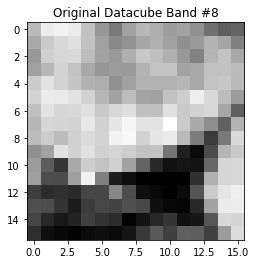

In [11]:
#@title Datacube { run: "auto", vertical-output: true }
band = 8 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data, title="Original Datacube")
plotlib.plot_band(data=data, band=band, title=f"Original Datacube Band #{band}")


# Compression

Compress the original datacube using the FPCNN network. The compressed datacube spit out by FPCNN is an array of residuals between the original datacube voxels and the voxels predicted by the network.

In [12]:
# instantiate compressor model
model = models.FPCNN(hp=hyperparams, logname="compress_ip")

# get initial weights and biases to encode later
weights = model.get_weights()

In [13]:
#@title Info { vertical-output: true, display-mode: "form" }

print("Compressor model architecture:")
model.print_model()

print("Initial compressor weights and biases:")
print(weights)

Compressor model architecture:
Model: "FPCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Spatial_Context (InputLayer)    [(None, 12)]         0                                            
__________________________________________________________________________________________________
Spectral_Context (InputLayer)   [(None, 4)]          0                                            
__________________________________________________________________________________________________
Spatial_Extraction (Dense)      (None, 5)            65          Spatial_Context[0][0]            
__________________________________________________________________________________________________
Spectral_Extraction (Dense)     (None, 5)            25          Spectral_Context[0][0]           
_______________________________________________________________

In [14]:
%%time

# encode original datacube
data_compressed = model.compress(data=data)

LOG.info(
    f"Data compressed ({data_compressed.shape}, {data_compressed.dtype}):\n"
    f"{data_compressed}"
)

CPU times: user 25.2 s, sys: 77.3 ms, total: 25.2 s
Wall time: 25.5 s


In [15]:
#@title Info { vertical-output: true, display-mode: "form" }

# plot error
df = pd.DataFrame(data=data.flatten(), index=None, columns=["error"], dtype=None, copy=False)
plotlib.plot_series(
    df=df,
    title="Prediction Coding Error",
    traces=["error"],
    indicies=None,
    x_errors=None,
    y_errors=None,
    title_x="Epoch",
    title_y="Error",
    size=None,
    draw_mode="lines+markers",
    vlines=None,
    hlines=None,
    dark_mode=dark_mode,
)

# plot distributions
stack = np.stack((data.flatten(), data_compressed.flatten()), axis=1, out=None)
df = pd.DataFrame(
    data=stack, index=None, columns=["original", "residuals"], dtype=None, copy=False
)
plotlib.plot_dist(
    df=df,
    title="Original Datacube vs Residuals Distribution",
    traces=["original","residuals"],
    nbins=None,
    x_errors=None,
    y_errors=None,
    title_x="Value",
    title_y="Count",
    size=None,
    vlines=None,
    hlines=None,
    dark_mode=dark_mode,
)

Ndarray Stats: Residuals Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	int16
Bytes:	8192 (0.01MB)
Range:	-4230,3229 (7459)
Mean:	46.17
Median:	8.0
σ:	454.37
σ²:	206455.59



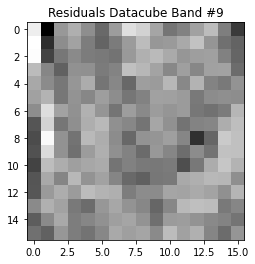

In [25]:
#@title Datacube { run: "auto", vertical-output: true, display-mode: "form" }
band = 9 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data_compressed, title="Residuals Datacube")
plotlib.plot_band(data=data_compressed, band=band, title=f"Residuals Datacube Band #{band}")

# Mapping

Flatten the residuals datacube into a one-dimensional array and map the positive and negative values to solely positive values using an overlap and interleave scheme.

In [26]:
%%time
data_mapped = encoding.map_residuals(data_compressed)

CPU times: user 6.13 ms, sys: 3 µs, total: 6.13 ms
Wall time: 6.6 ms


In [27]:
#@title Info { vertical-output: true, display-mode: "form" }

# plot distributions
stack = np.stack((data_compressed.flatten(), data_mapped.flatten()), axis=1, out=None)
df = pd.DataFrame(
    data=stack, index=None, columns=["residuals", "mapped"], dtype=None, copy=False
)
plotlib.plot_dist(
    df=df,
    title="Residuals vs Mapped Distribution",
    traces=["residuals","mapped"],
    nbins=None,
    x_errors=None,
    y_errors=None,
    title_x="Value",
    title_y="Count",
    size=None,
    vlines=None,
    hlines=None,
    dark_mode=dark_mode,
)

printlib.print_ndarray_stats(array=data_mapped, title="Mapped")

Ndarray Stats: Mapped
Shape:	(4096,)
Size:	4096
Dims:	1
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	0,8459 (8459)
Mean:	489.1
Median:	250.0
σ:	771.19
σ²:	594728.43
[6344 2459 4856 3865 4492]...[ 55 100 150  89 121]



# Encoding

Encode the mapped array to binary using Goloumb-Rice coding. After this step the data is ready to be transmitted.

In [28]:
%%time
# encode using grc
data_encoded = encoding.grc_encode(data=data_mapped, m=grc_m)

CPU times: user 55.4 ms, sys: 66 µs, total: 55.5 ms
Wall time: 61.3 ms


In [29]:
#@title Info { vertical-output: true, display-mode: "form" }

printlib.print_ndarray_stats(array=data_encoded, title="Encoding")

Ndarray Stats: Encoding
Shape:	(49378,)
Size:	49378
Dims:	1
Type:	uint8
Bytes:	49378 (0.05MB)
Range:	0,1 (1)
Mean:	0.37
Median:	0.0
σ:	0.48
σ²:	0.23
[1 1 1 0 0]...[1 1 0 0 1]



# Decoding

Decode the received bitstream.

In [30]:
%%time
data_decoded = encoding.grc_decode(code=data_encoded, m=grc_m)

CPU times: user 81.2 ms, sys: 16 µs, total: 81.2 ms
Wall time: 86.1 ms


In [31]:
#@title Info { vertical-output: true, display-mode: "form" }

printlib.print_ndarray_stats(array=data_decoded, title="Decoding")

# acc = benchmarklib.get_acc(A=data_mapped, B=data_decoded)
# print(f"Decoding accuracy:\t{acc*100}%")




Ndarray Stats: Decoding
Shape:	(4096,)
Size:	4096
Dims:	1
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	0,8459 (8459)
Mean:	489.1
Median:	250.0
σ:	771.19
σ²:	594728.43
[6344 2459 4856 3865 4492]...[ 55 100 150  89 121]

Decoding accuracy:	100.0%


# Remapping

Remap the decoded bitstream of positive intergers back to their original positive and negative values using the inverse of the overlap and interleave scheme. Also reshape the one-dimensional array back to a three-dimensional array.

In [32]:
%%time
data_remapped = encoding.remap_residuals(data=data_decoded)
data_reshaped = data_remapped.reshape(data_shape)

CPU times: user 5.43 ms, sys: 0 ns, total: 5.43 ms
Wall time: 7.37 ms


In [33]:
#@title Info { vertical-output: true, display-mode: "form" }

# acc = benchmarklib.get_acc(A=data_compressed.flatten(), B=data_reshaped.flatten())
# print(f"Remapping accuracy:\t{acc*100}%")

Remapping accuracy:	100.0%


Ndarray Stats: Recovered Residuals Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	int16
Bytes:	8192 (0.01MB)
Range:	-4230,3229 (7459)
Mean:	46.17
Median:	8.0
σ:	454.37
σ²:	206455.98



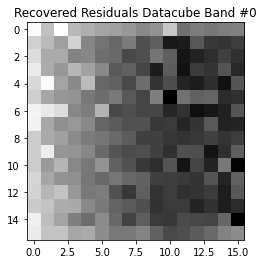

In [ ]:
#@title Datacube { run: "auto", vertical-output: true, display-mode: "form" }
band = 0 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data_reshaped, title="Recovered Residuals Datacube")
plotlib.plot_band(data=data_reshaped, band=band, title=f"Recovered Residuals Datacube Band #{band}")

# Decompression

Decompress the residuals datacube by running the decompression variant of the FPCNN algorithm. The output of the decompressor is the original datacube.

In [ ]:
%%time
# instantiate compressor model
model_decompressor = models.FPCNN(hp=hyperparams, logname="decompress_ip")
model_decompressor.set_weights(weights)
data_recovered = model_decompressor.decompress_legacy(data_reshaped)

In [ ]:
#@title Info { vertical-output: true, display-mode: "form" }
# acc = benchmarklib.get_acc(A=data.flatten(), B=data_recovered.flatten())
print(f"Decompression accuracy:\t{acc*100}%")

Decompression accuracy:	100.0%


Ndarray Stats: Recovered Datacube
Shape:	(16, 16, 16)
Size:	4096
Dims:	3
Type:	uint16
Bytes:	8192 (0.01MB)
Range:	2560,5598 (3038)
Mean:	4470.45
Median:	4567.0
σ:	636.3
σ²:	404883.57



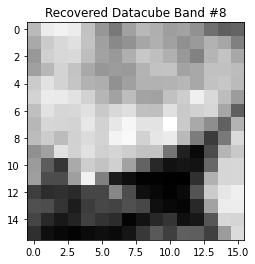

In [ ]:
#@title Datacube { run: "auto", vertical-output: true }
band = 8 #@param {type:"slider", min:0, max:64, step:1}

printlib.print_ndarray_stats(array=data_recovered, title="Recovered Datacube")
plotlib.plot_band(data=data_recovered, band=band, title=f"Recovered Datacube Band #{band}")

# Benchmarking

In [ ]:
# WIP (calculation of compression factor, etc)